In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from captum.attr import IntegratedGradients
from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pickle
BASE_PATH = "/kaggle/input/cifar-wec/cifar-10-batches-py"

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict

In [5]:
from PIL import Image
test_path = os.path.join(BASE_PATH, 'test_batch')
test_batch = unpickle(test_path)

test_data = test_batch[b'data']       # shape (10000, 3072)
test_labels = np.array(test_batch[b'labels'])

# Convert a single flat image to PIL
def cifar_flat_to_pil(img_flat):
    img_flat = np.array(img_flat)   # ensure numpy array
    r = img_flat[0:1024].reshape(32, 32)
    g = img_flat[1024:2048].reshape(32, 32)
    b = img_flat[2048:3072].reshape(32, 32)
    img = np.stack([r, g, b], axis=2).astype('uint8')
    return Image.fromarray(img)

# Convert all images to PIL
def cifar_dataset_to_pil(flat_images):
    return [cifar_flat_to_pil(img) for img in flat_images]

# Now convert all test images
test_images = cifar_dataset_to_pil(test_data)

In [6]:
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Define the model architecture first
efficientnet_b0 = models.efficientnet_b0(weights=None, num_classes=10)  # CIFAR-10 has 10 classes
resnet18 = models.resnet18(weights=None, num_classes=10)
vgg16 = models.vgg16(weights=None, num_classes=10)

# 2. Load the state dict
efficientnet_b0.load_state_dict(torch.load('/kaggle/input/3-models-combines/pytorch/default/1/best_EfficientNet_B0.pth'))
resnet18.load_state_dict(torch.load('/kaggle/input/3-models-combines/pytorch/default/1/best_ResNet18.pth'))
vgg16.load_state_dict(torch.load('/kaggle/input/3-models-combines/pytorch/default/1/best_VGG16.pth'))

# 3. Move to device and set eval mode
efficientnet_b0 = efficientnet_b0.to(device).eval()
resnet18 = resnet18.to(device).eval()
vgg16 = vgg16.to(device).eval()

models_dict = {
    'EfficientNet-B0': efficientnet_b0,
    'ResNet18': resnet18,
    'VGG16': vgg16
}

In [27]:
def find_last_conv(module):
    convs = [m for m in module.modules() if isinstance(m, torch.nn.Conv2d)]
    return convs[-1] if convs else None

target_layers_dict = {
    'EfficientNet-B0': find_last_conv(efficientnet_b0.features[6]),  # last Conv2d in final MBConv block
    'ResNet18': resnet18.layer3[-1].conv2,
    'VGG16': vgg16.features[-3]
}

# Quick check
for name, layer in target_layers_dict.items():
    print(f"{name}: {layer}")


EfficientNet-B0: Conv2d(1152, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
ResNet18: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
VGG16: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [10]:
def preprocess_image(img_np, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    img_tensor = torch.tensor(img_np.transpose(2,0,1)).unsqueeze(0).float().to(device)
    mean = torch.tensor(mean).view(1,3,1,1).to(device)
    std = torch.tensor(std).view(1,3,1,1).to(device)
    img_tensor = (img_tensor - mean)/std
    return img_tensor


Grad-CAM visualization for EfficientNet-B0 ...


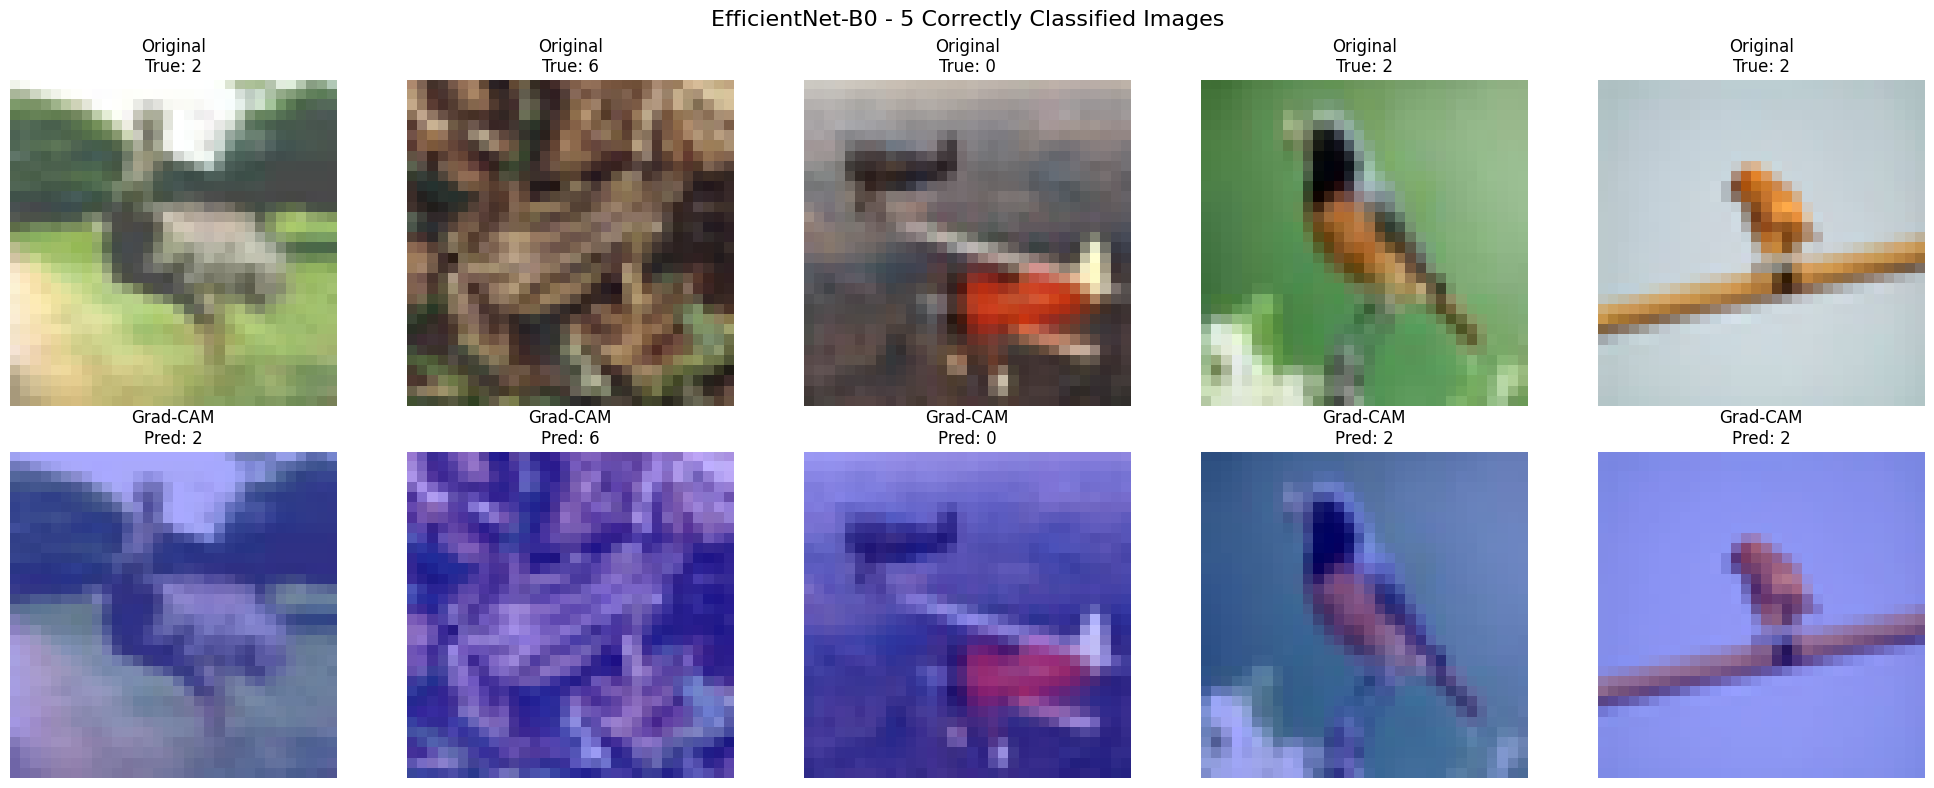

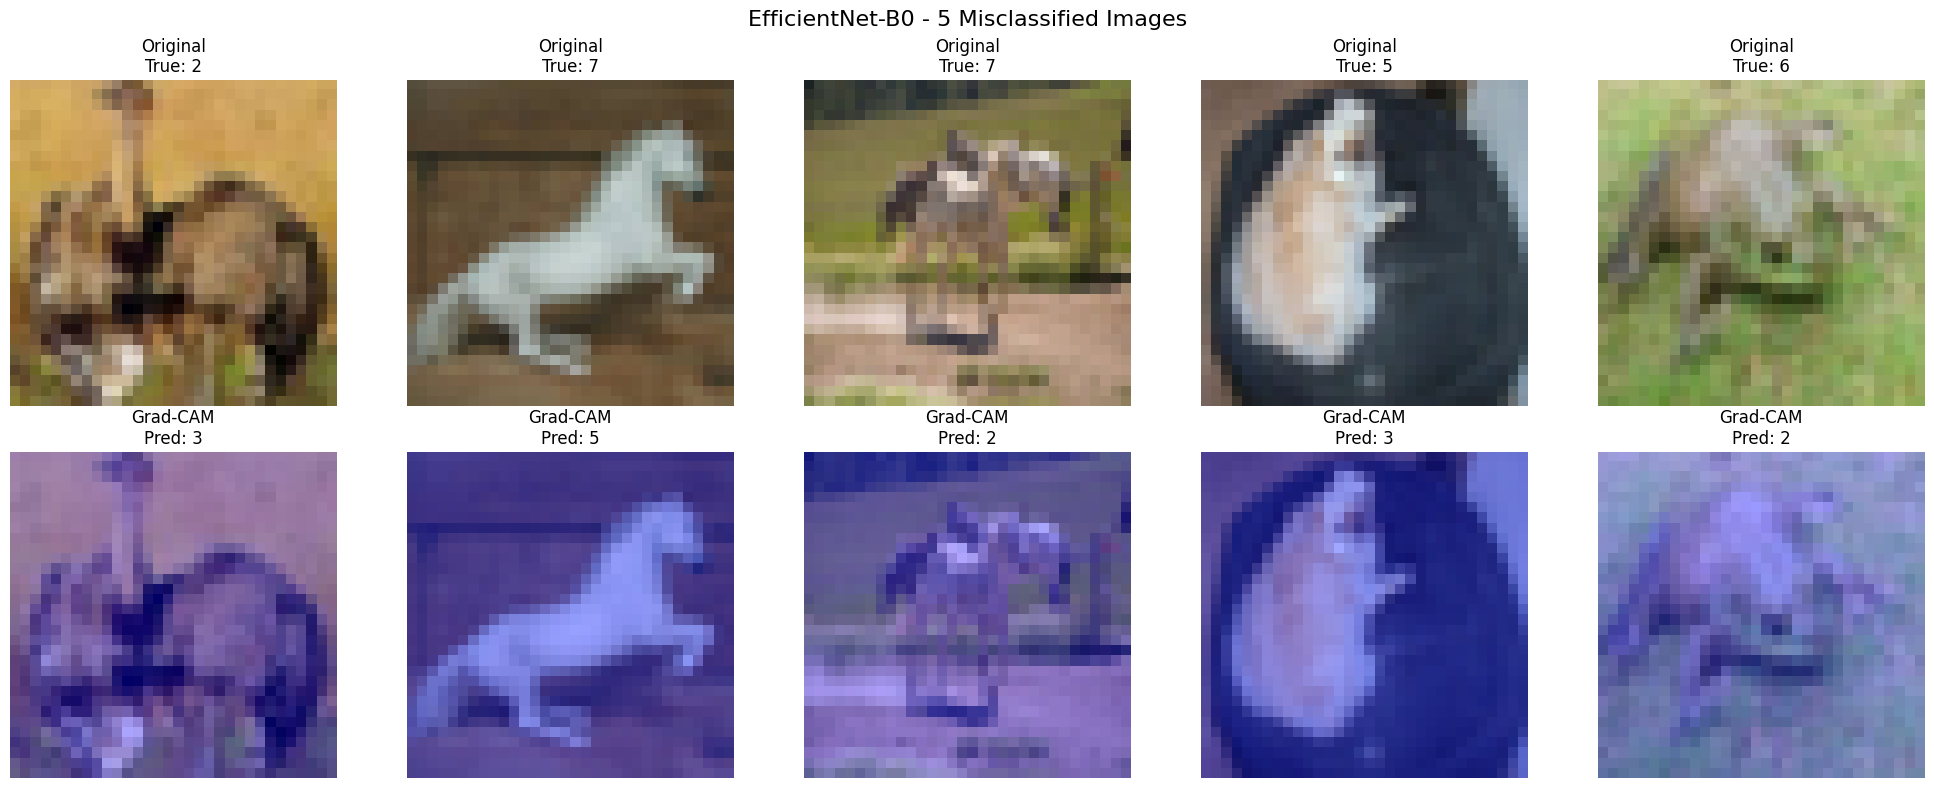


Grad-CAM visualization for ResNet18 ...


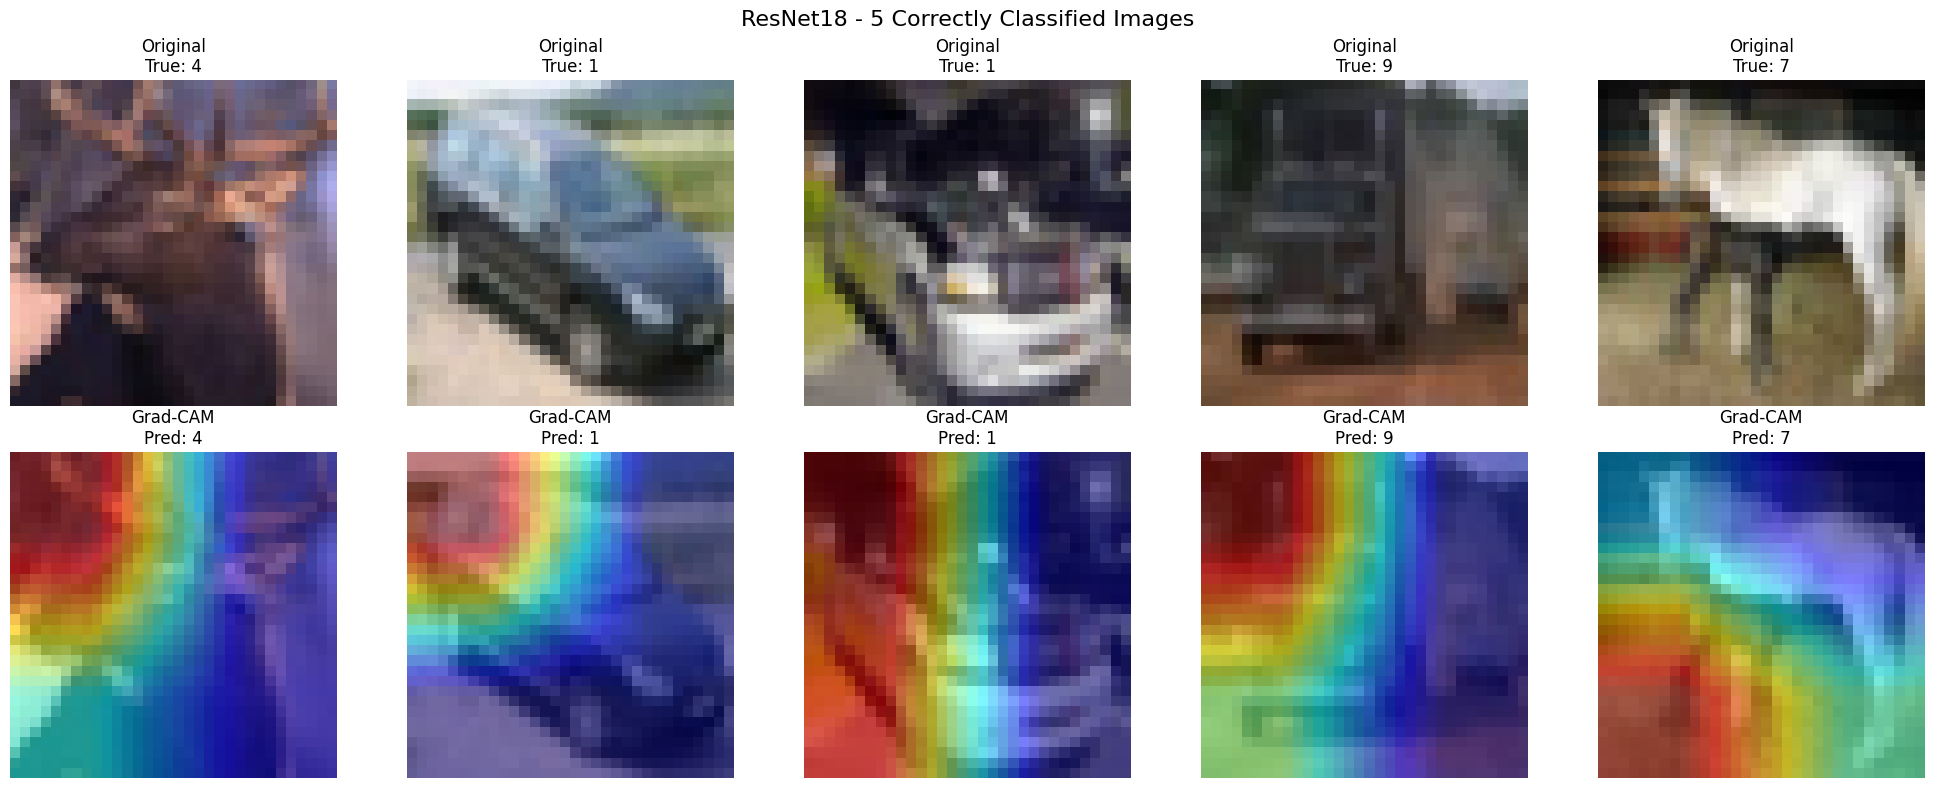

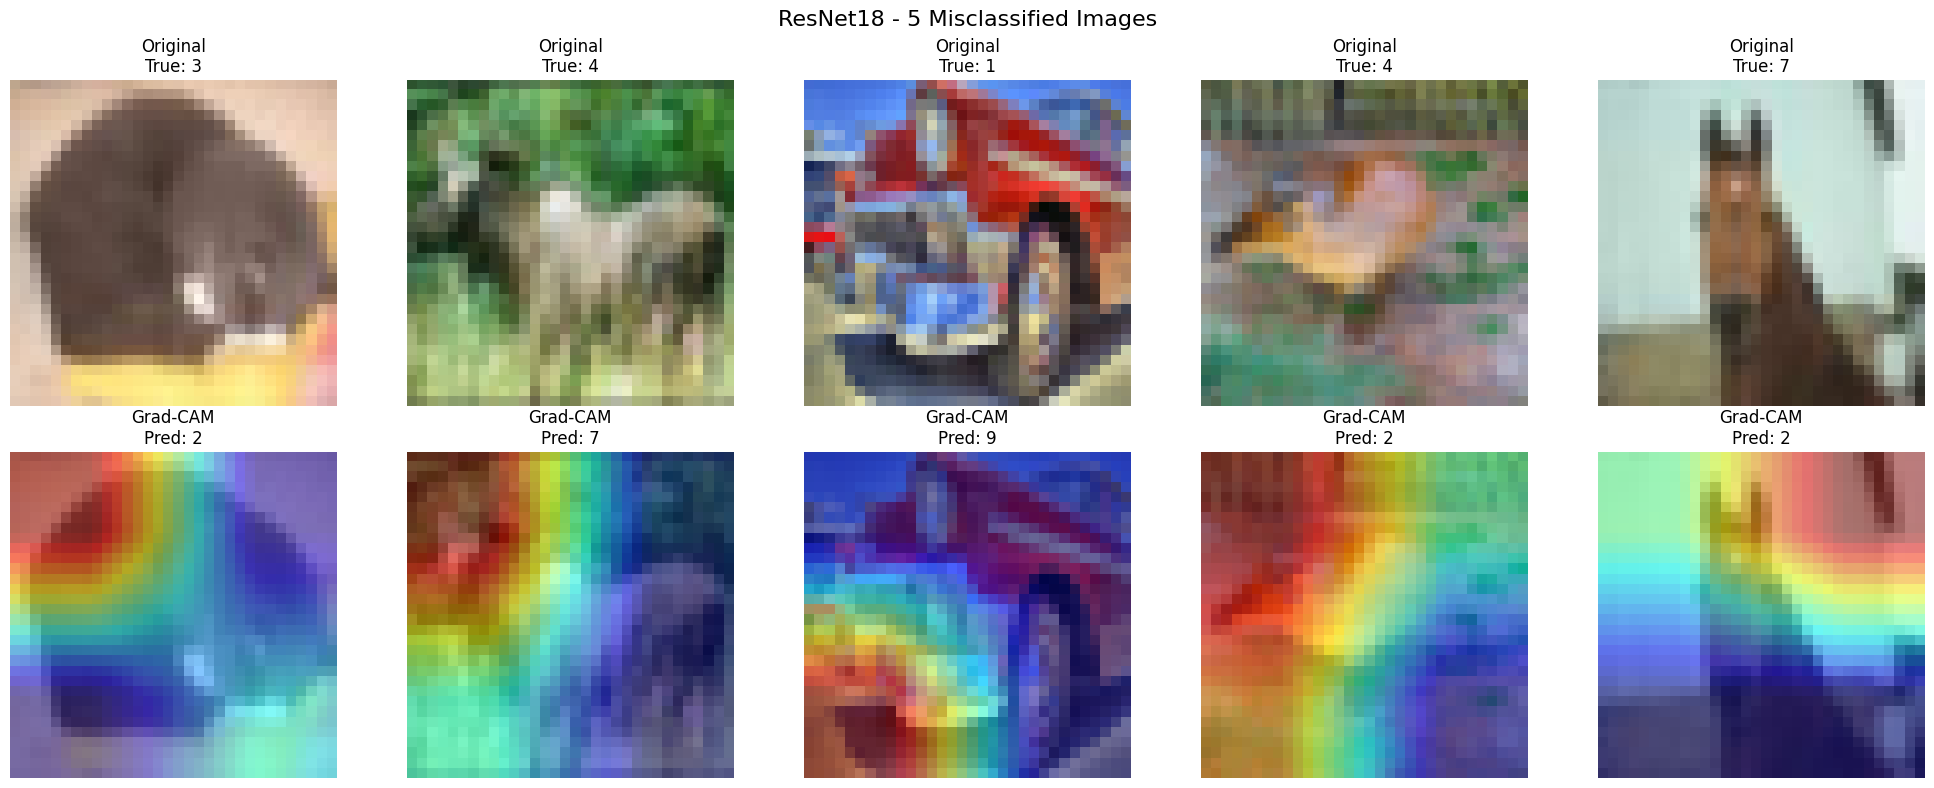


Grad-CAM visualization for VGG16 ...


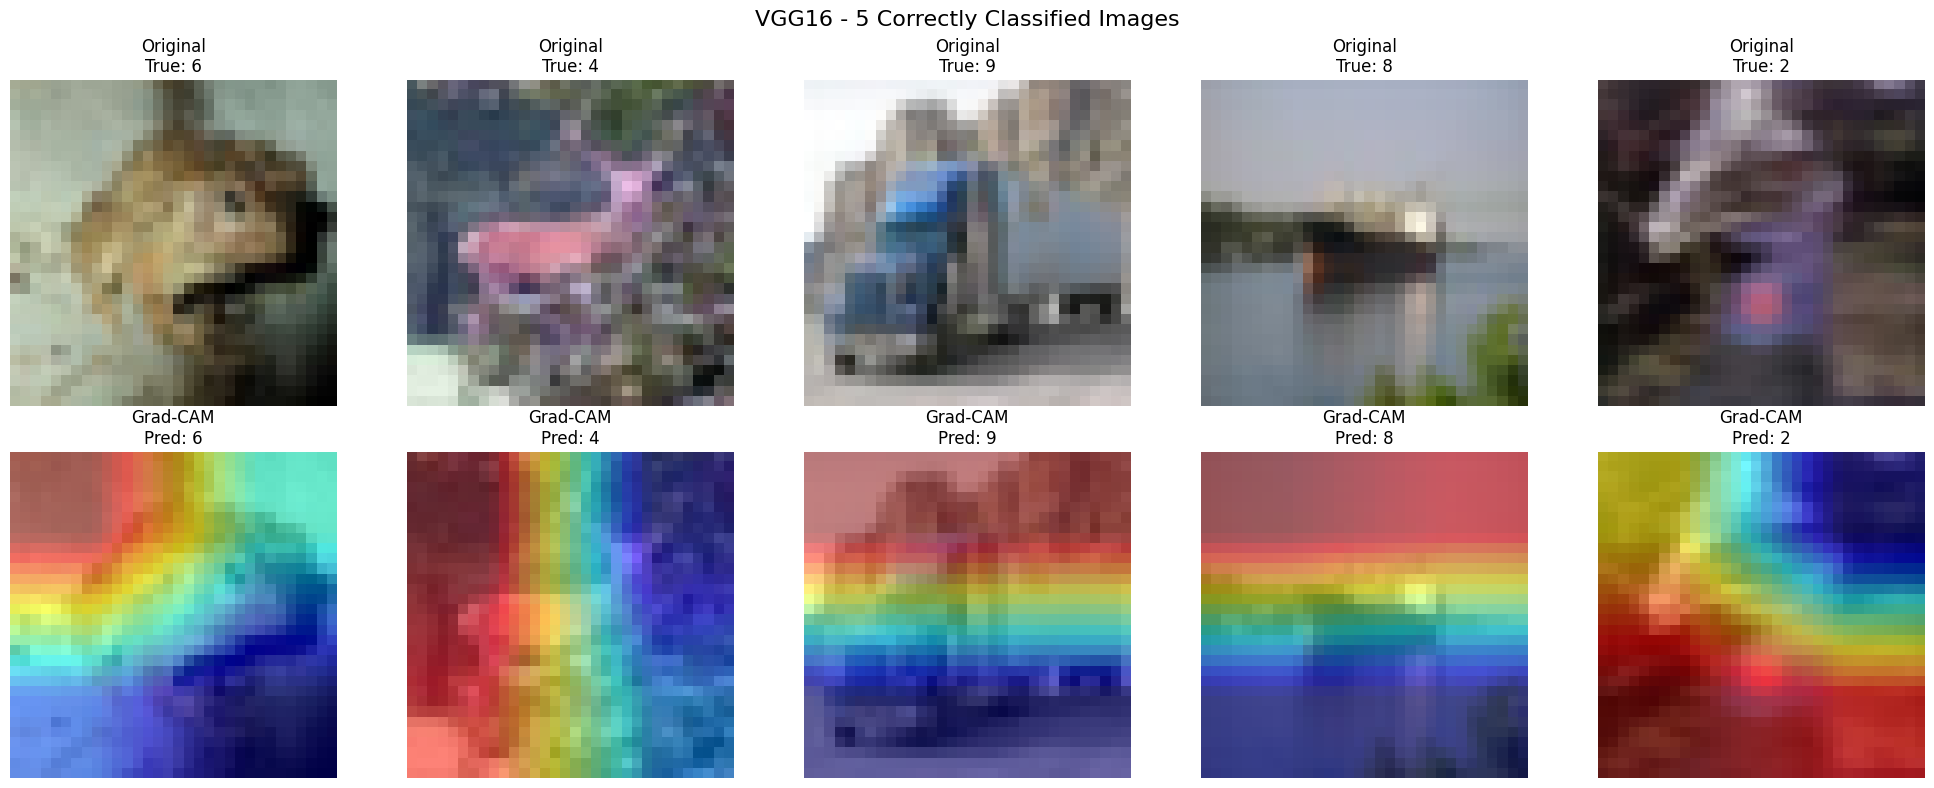

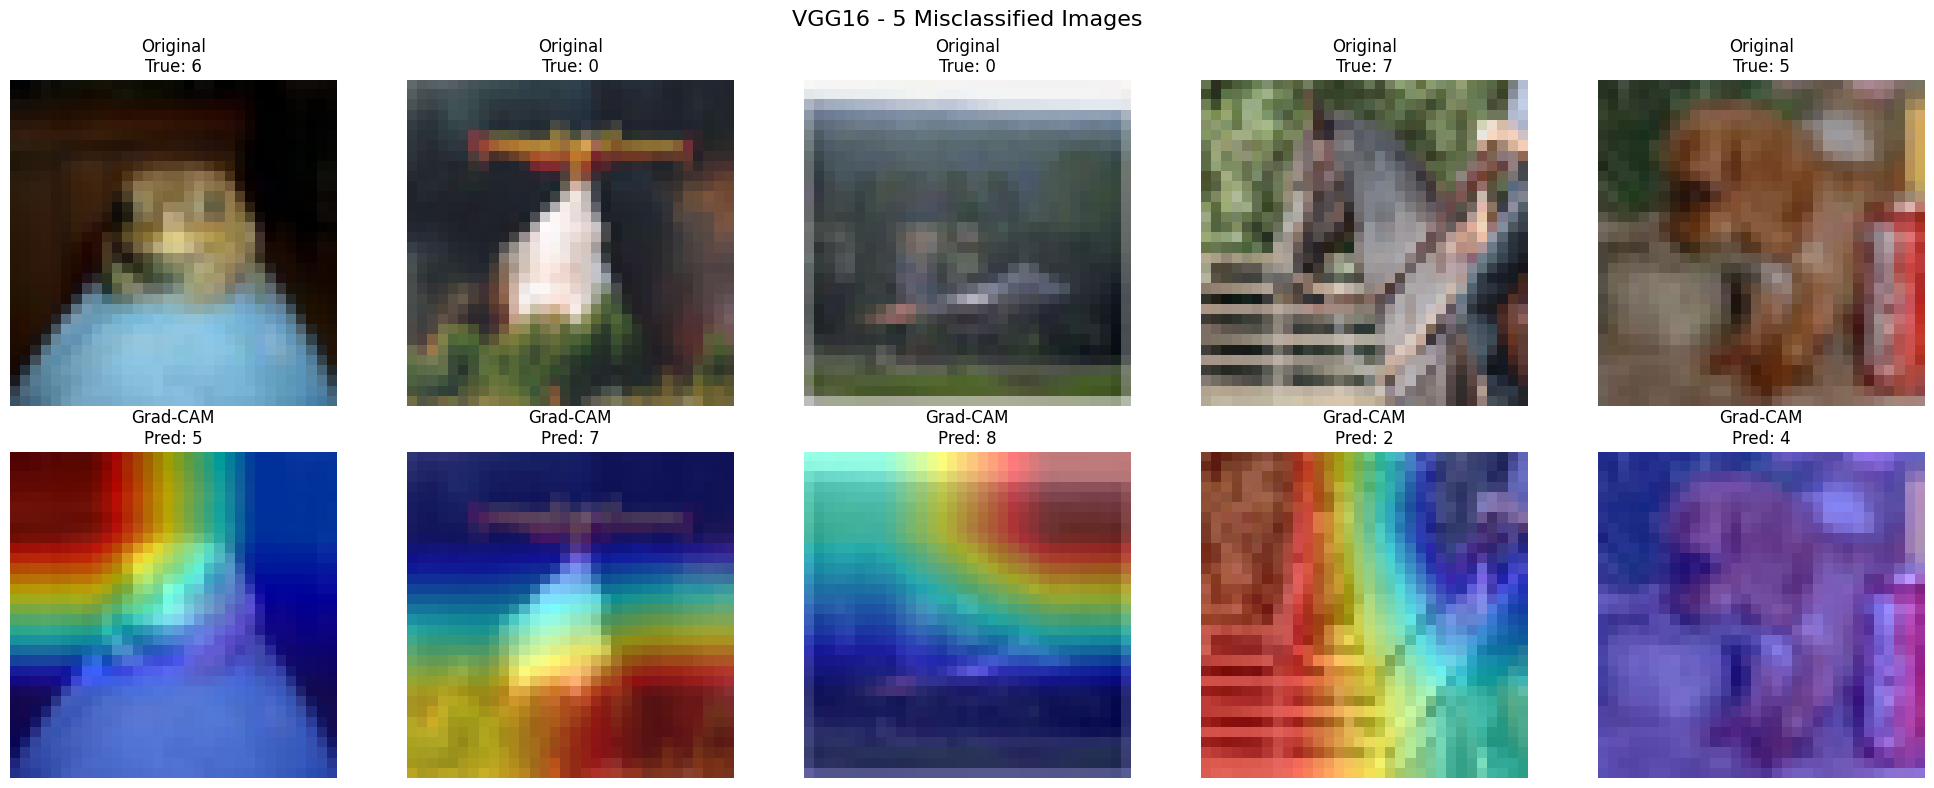

In [28]:
# =======================
# Models dict (only models, not tuples)
# =======================
models_dict = {
    'EfficientNet-B0': efficientnet_b0,
    'ResNet18': resnet18,
    'VGG16': vgg16
}

# =======================
# Predictions & correct flags
# =======================
all_predictions = {}
all_correct_flags = {}

for model_name, net in models_dict.items():
    net.eval()
    preds = []
    correct_flags = []
    
    with torch.no_grad():
        for img, label in zip(test_images, test_labels):
            input_tensor = preprocess_image(np.float32(img)/255.0)
            output = net(input_tensor)
            pred = output.argmax(dim=1).item()
            preds.append(pred)
            correct_flags.append(pred == label)
    
    all_predictions[model_name] = preds
    all_correct_flags[model_name] = correct_flags

# =======================
# Grad-CAM loop now works
# =======================
num_samples = 5  # per category

for model_name, net in models_dict.items():
    print(f"\nGrad-CAM visualization for {model_name} ...")
    
    target_layer = target_layers_dict[model_name]  # pick last conv layer
    cam = GradCAM(model=net, target_layers=[target_layer])
    net.eval()
    
    # Indices
    correct_indices = [i for i, c in enumerate(all_correct_flags[model_name]) if c]
    misclassified_indices = [i for i, c in enumerate(all_correct_flags[model_name]) if not c]
    
    def sample_indices(indices):
        return random.sample(indices, min(num_samples, len(indices)))
    
    def get_gradcam_image(idx):
        img_np = np.float32(test_images[idx])/255.0
        input_tensor = preprocess_image(img_np)
        with torch.no_grad():
            pred_class = net(input_tensor).argmax(dim=1).item()
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0, :]
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        return img_np, cam_image, pred_class
    
    def plot_images(indices, title_prefix):
        plt.figure(figsize=(20,8))
        for i, idx in enumerate(indices):
            orig, cam_img, pred = get_gradcam_image(idx)
            # Original image
            plt.subplot(2, num_samples, i+1)
            plt.imshow(orig)
            plt.title(f"Original\nTrue: {test_labels[idx]}")
            plt.axis("off")
            # Grad-CAM image
            plt.subplot(2, num_samples, i+1+num_samples)
            plt.imshow(cam_img)
            plt.title(f"Grad-CAM\nPred: {pred}")
            plt.axis("off")
        plt.suptitle(f"{model_name} - {num_samples} {title_prefix} Images", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Plot correct and misclassified images
    plot_images(sample_indices(correct_indices), "Correctly Classified")
    plot_images(sample_indices(misclassified_indices), "Misclassified")



Eigen-CAM visualization for EfficientNet-B0 ...


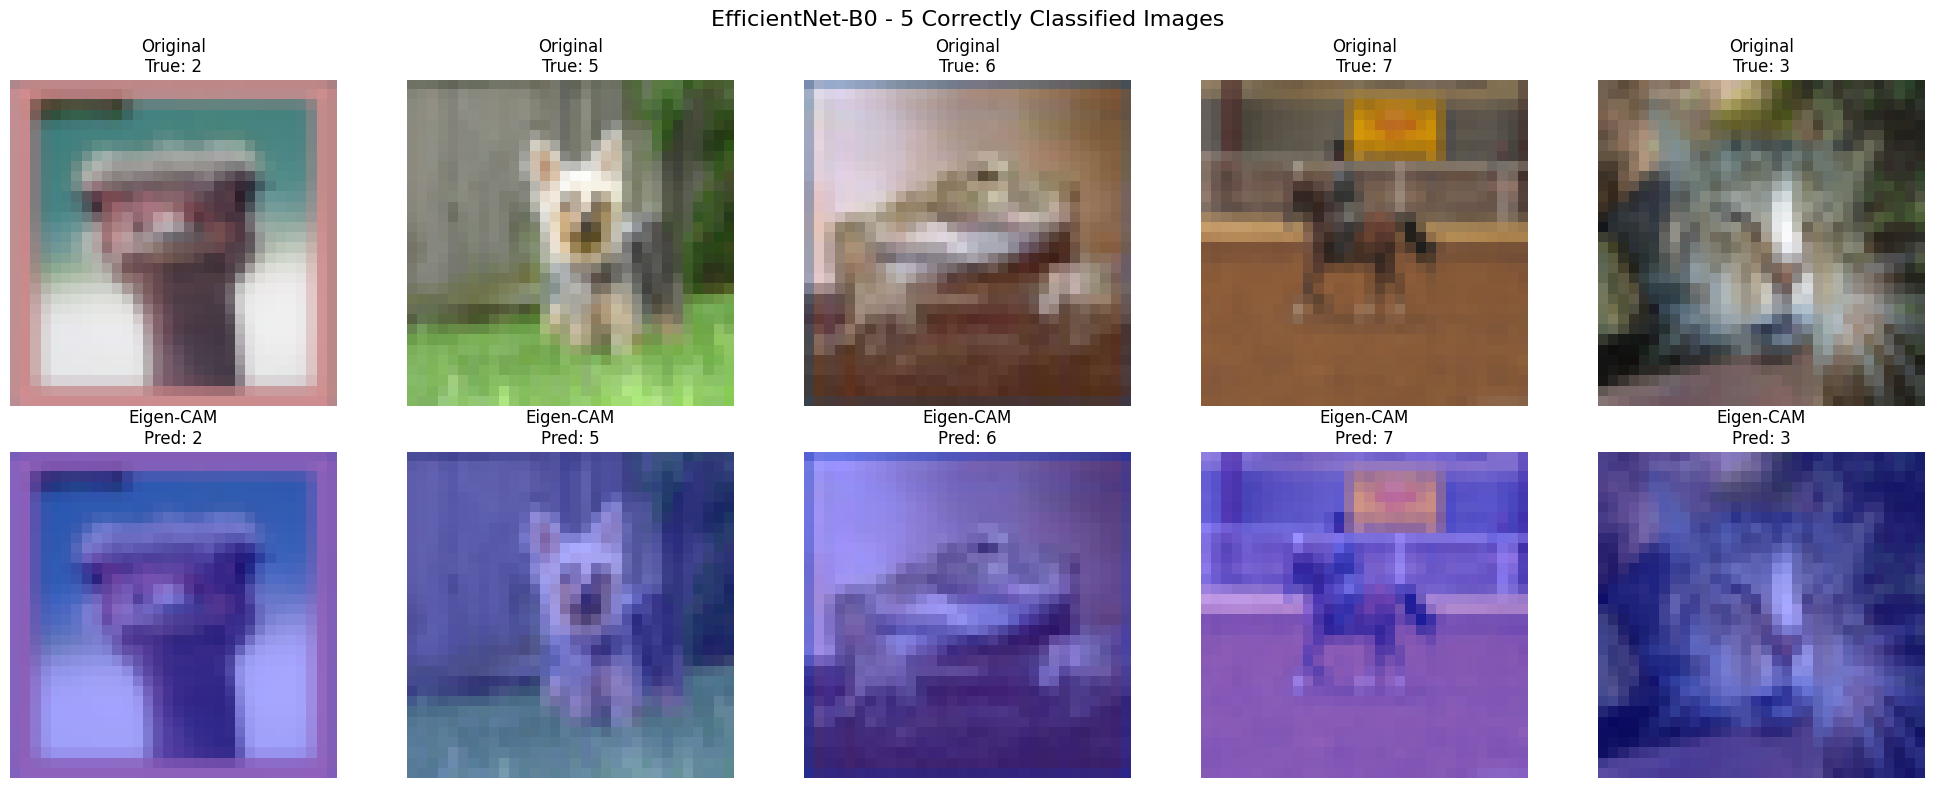

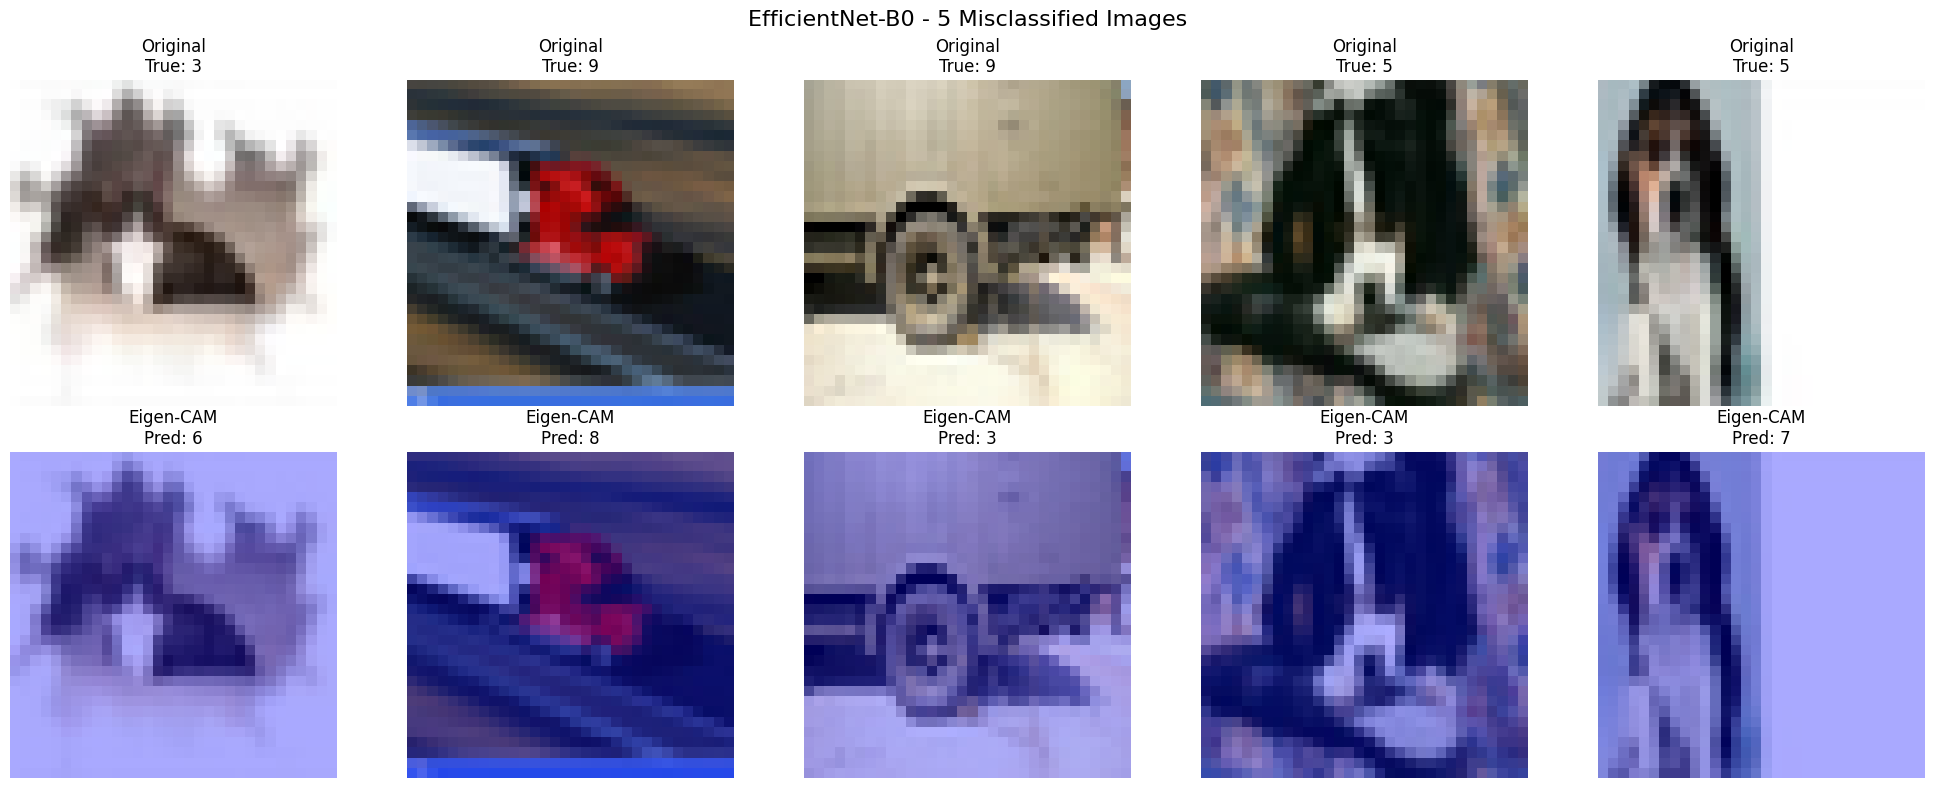


Eigen-CAM visualization for ResNet18 ...


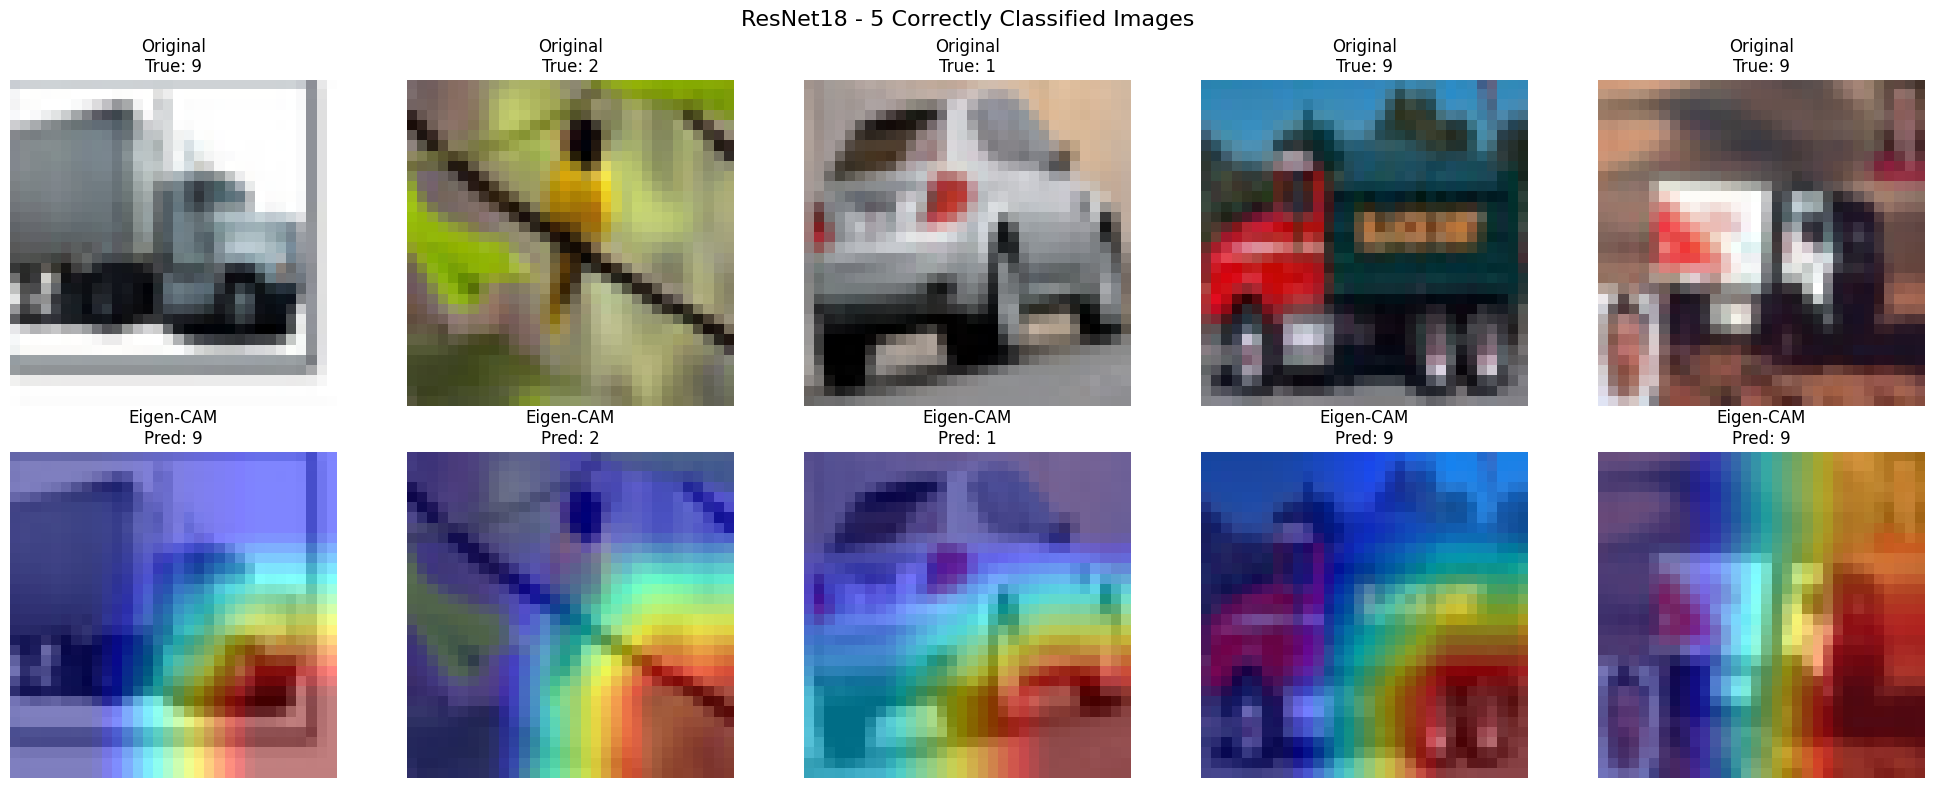

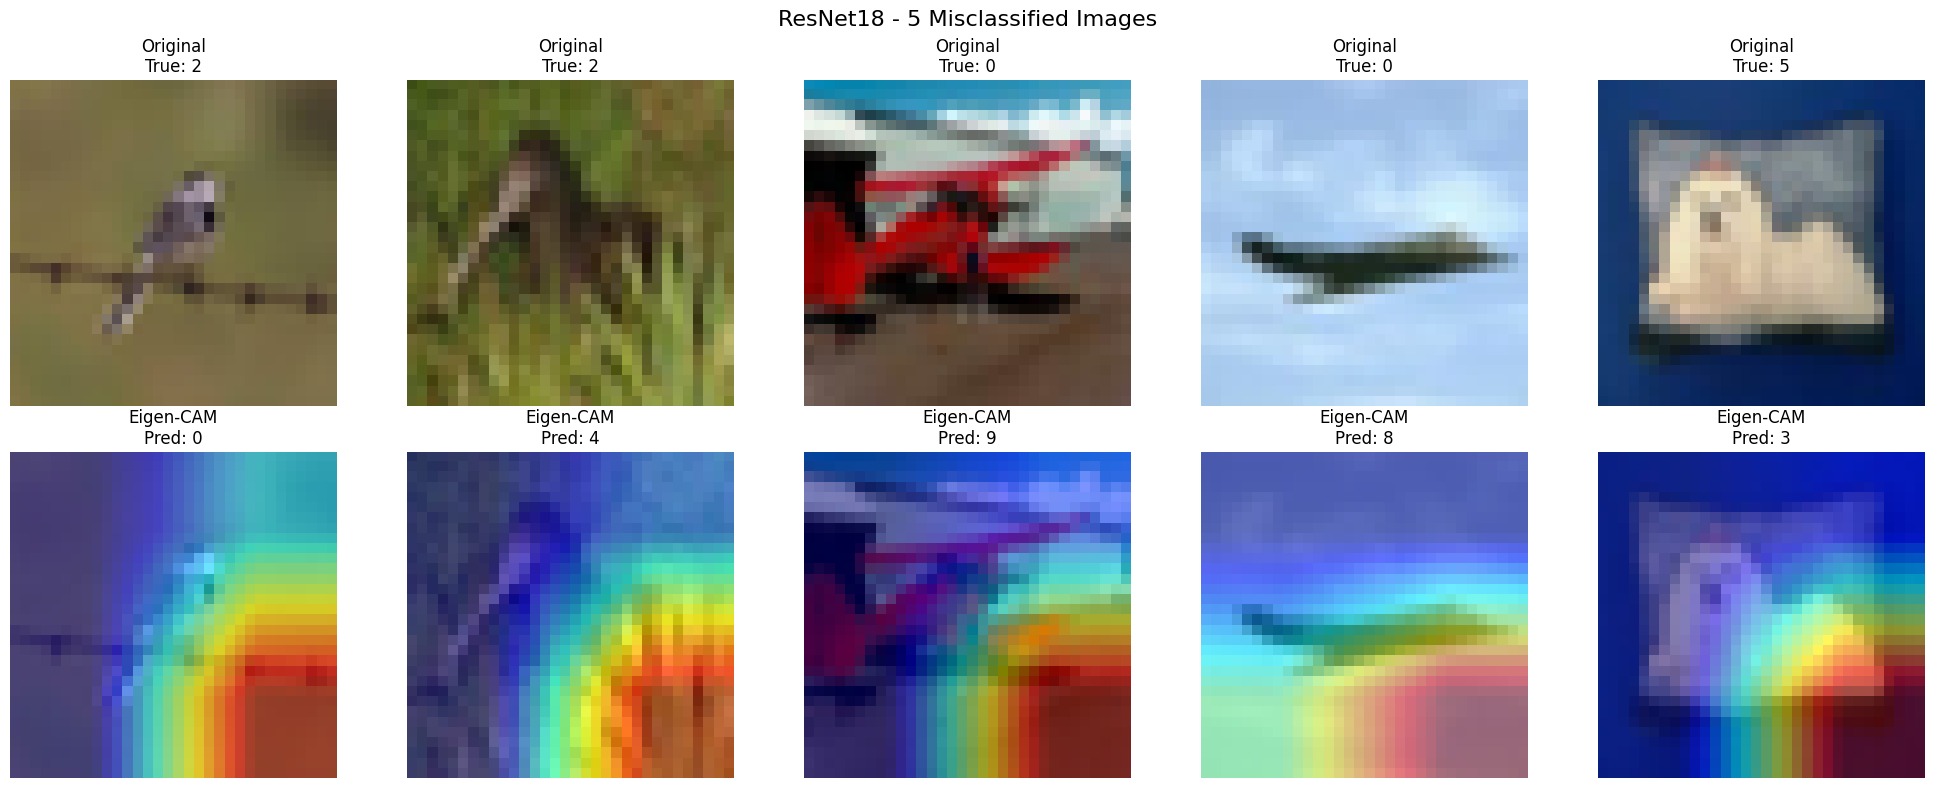


Eigen-CAM visualization for VGG16 ...


Exception ignored in: <function BaseCAM.__del__ at 0x7f518071cae0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pytorch_grad_cam/base_cam.py", line 212, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


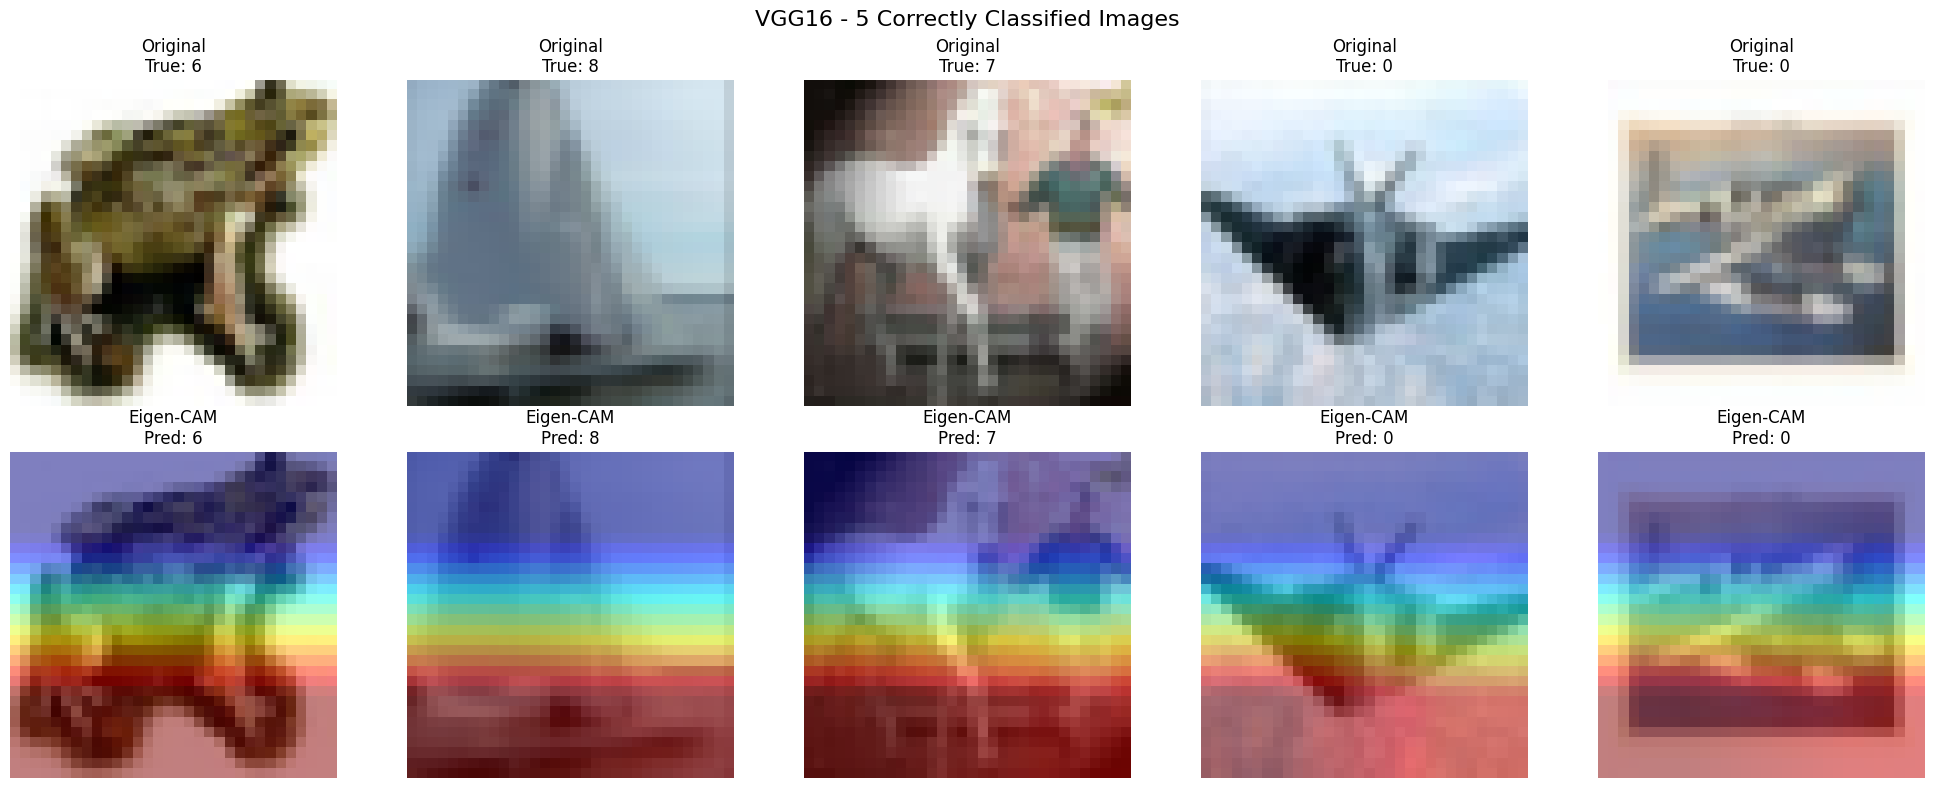

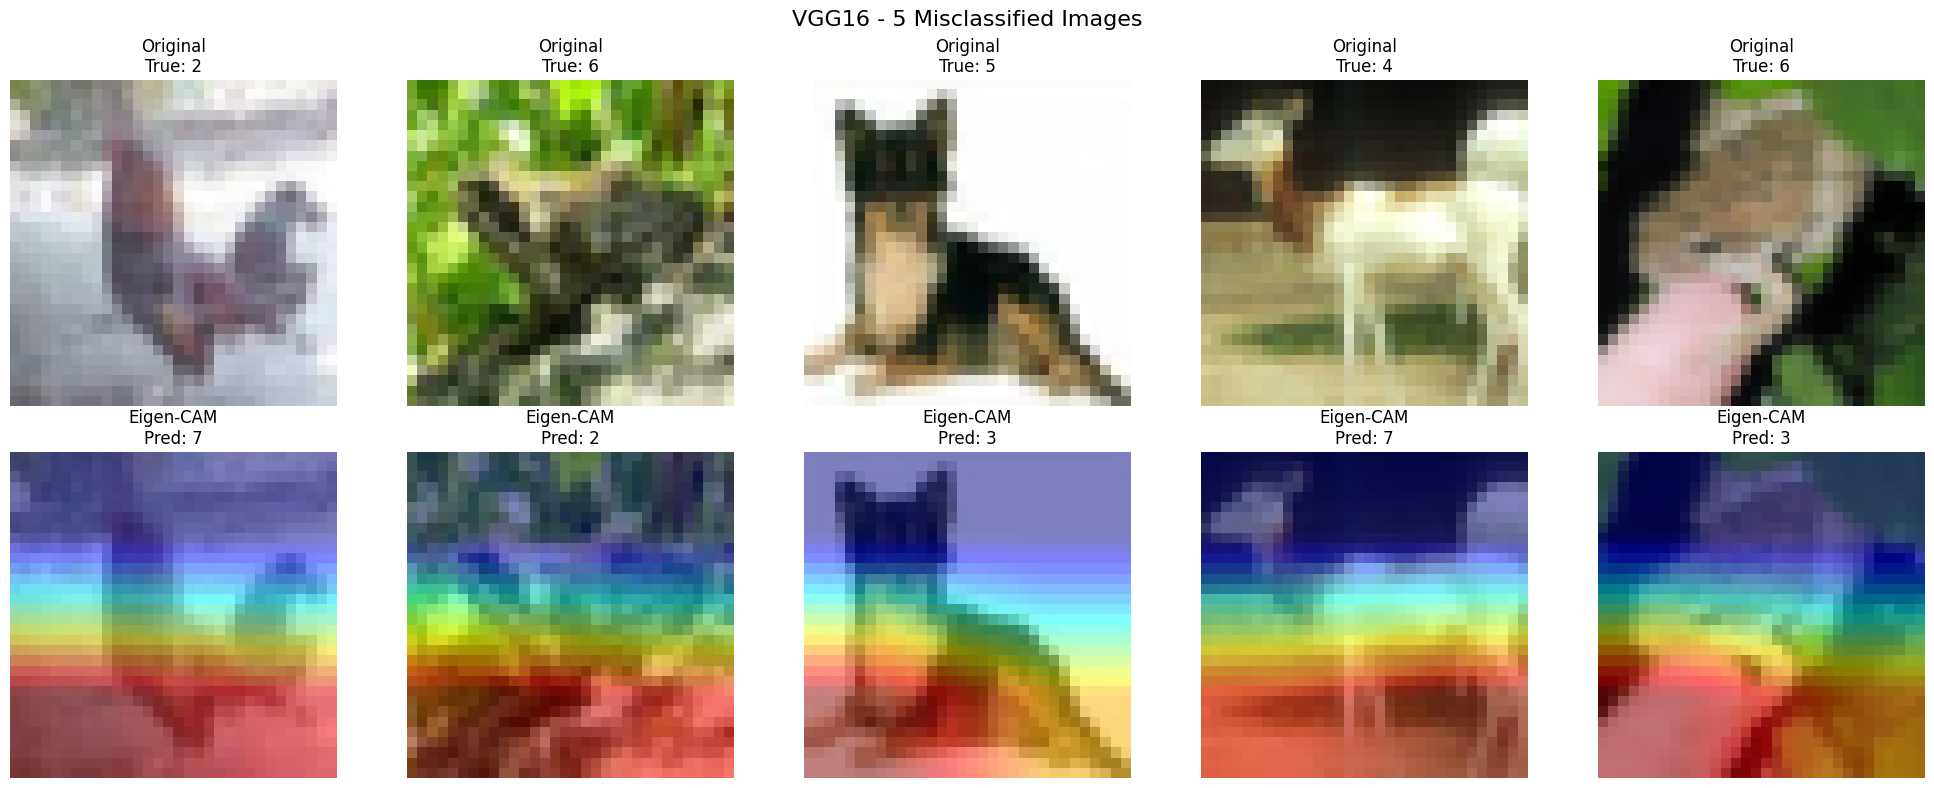

In [30]:
num_samples = 5  # per category

for model_name, net in models_dict.items():
    print(f"\nEigen-CAM visualization for {model_name} ...")
    
    target_layer = target_layers_dict[model_name]  # pick last conv layer
    cam = EigenCAM(model=net, target_layers=[target_layer])
    net.eval()
    
    # Indices
    correct_indices = [i for i, c in enumerate(all_correct_flags[model_name]) if c]
    misclassified_indices = [i for i, c in enumerate(all_correct_flags[model_name]) if not c]
    
    def sample_indices(indices):
        return random.sample(indices, min(num_samples, len(indices)))
    
    def get_eigencam_image(idx):
        img_np = np.float32(test_images[idx])/255.0
        input_tensor = preprocess_image(img_np)
        with torch.no_grad():
            pred_class = net(input_tensor).argmax(dim=1).item()
        # Eigen-CAM doesn't need targets
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        return img_np, cam_image, pred_class
    
    def plot_images(indices, title_prefix):
        plt.figure(figsize=(20,8))
        for i, idx in enumerate(indices):
            orig, cam_img, pred = get_eigencam_image(idx)
            # Original image
            plt.subplot(2, num_samples, i+1)
            plt.imshow(orig)
            plt.title(f"Original\nTrue: {test_labels[idx]}")
            plt.axis("off")
            # CAM image
            plt.subplot(2, num_samples, i+1+num_samples)
            plt.imshow(cam_img)
            plt.title(f"Eigen-CAM\nPred: {pred}")
            plt.axis("off")
        plt.suptitle(f"{model_name} - {num_samples} {title_prefix} Images", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Plot correct and misclassified images
    plot_images(sample_indices(correct_indices), "Correctly Classified")
    plot_images(sample_indices(misclassified_indices), "Misclassified")



Integrated Gradients visualization for EfficientNet-B0 ...


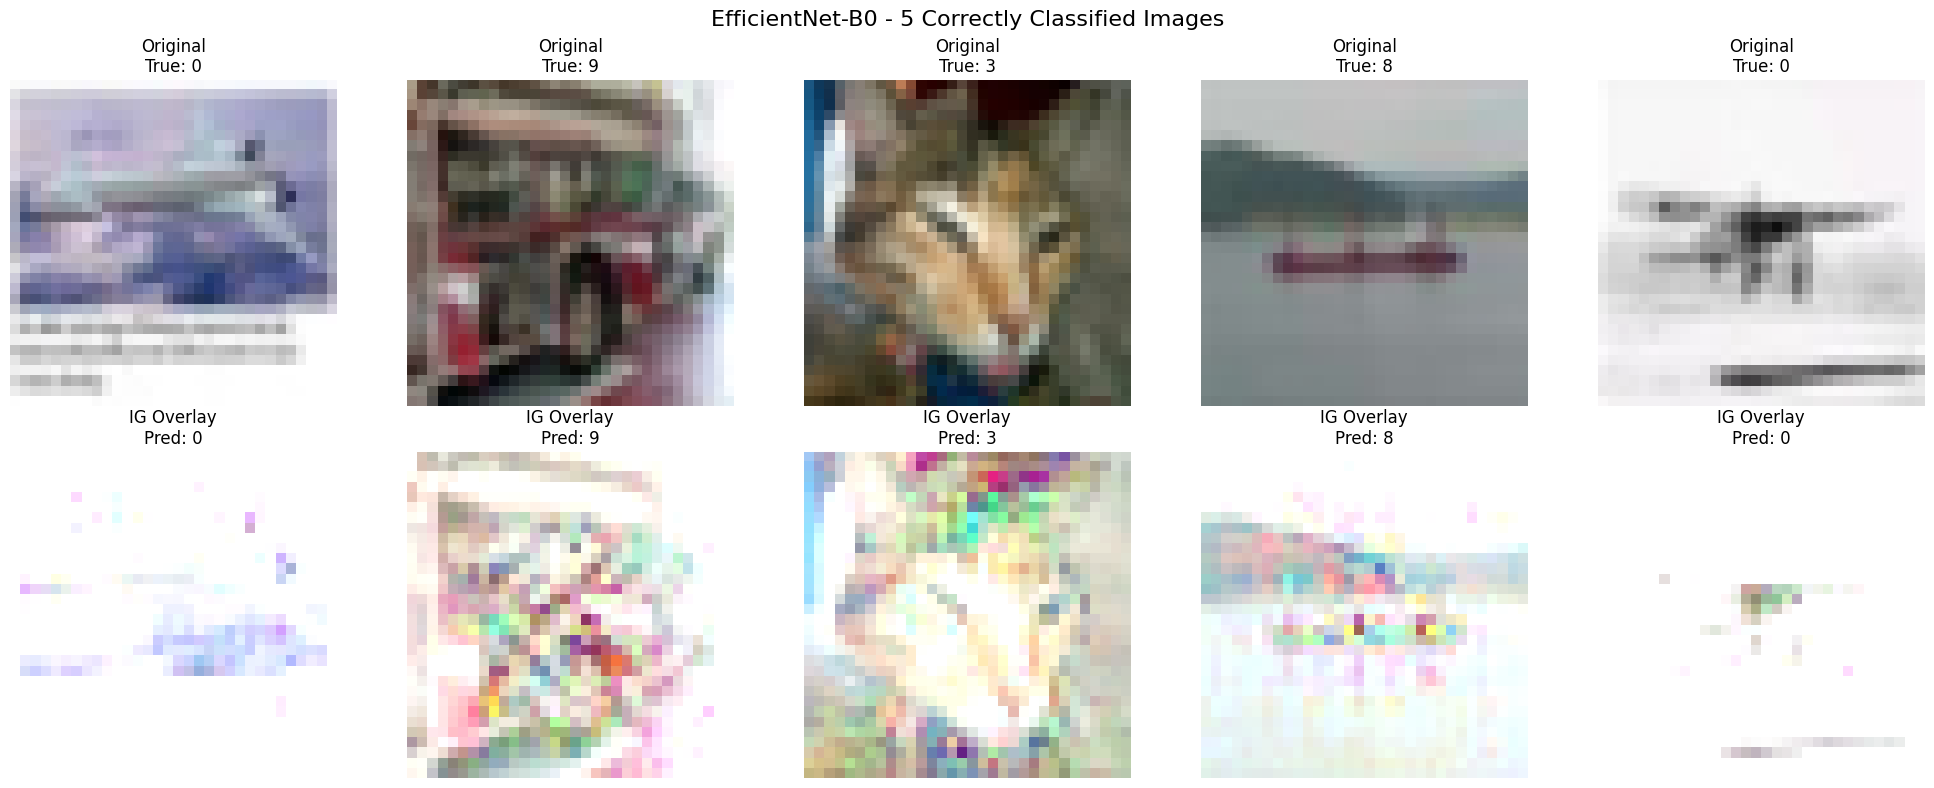

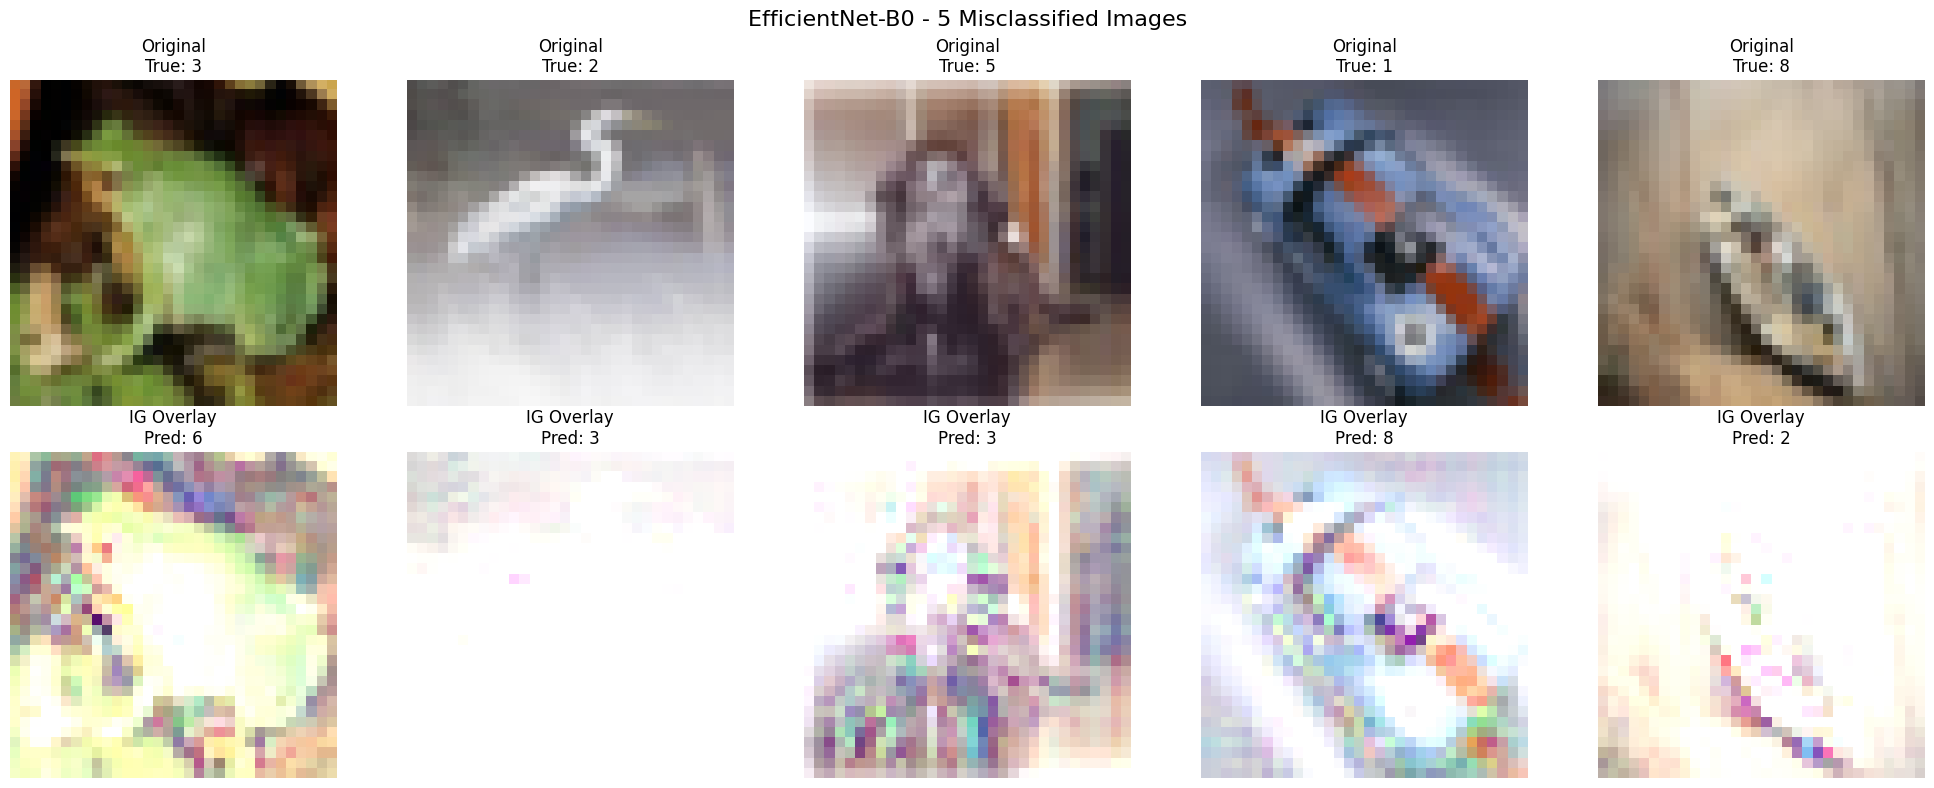


Integrated Gradients visualization for ResNet18 ...


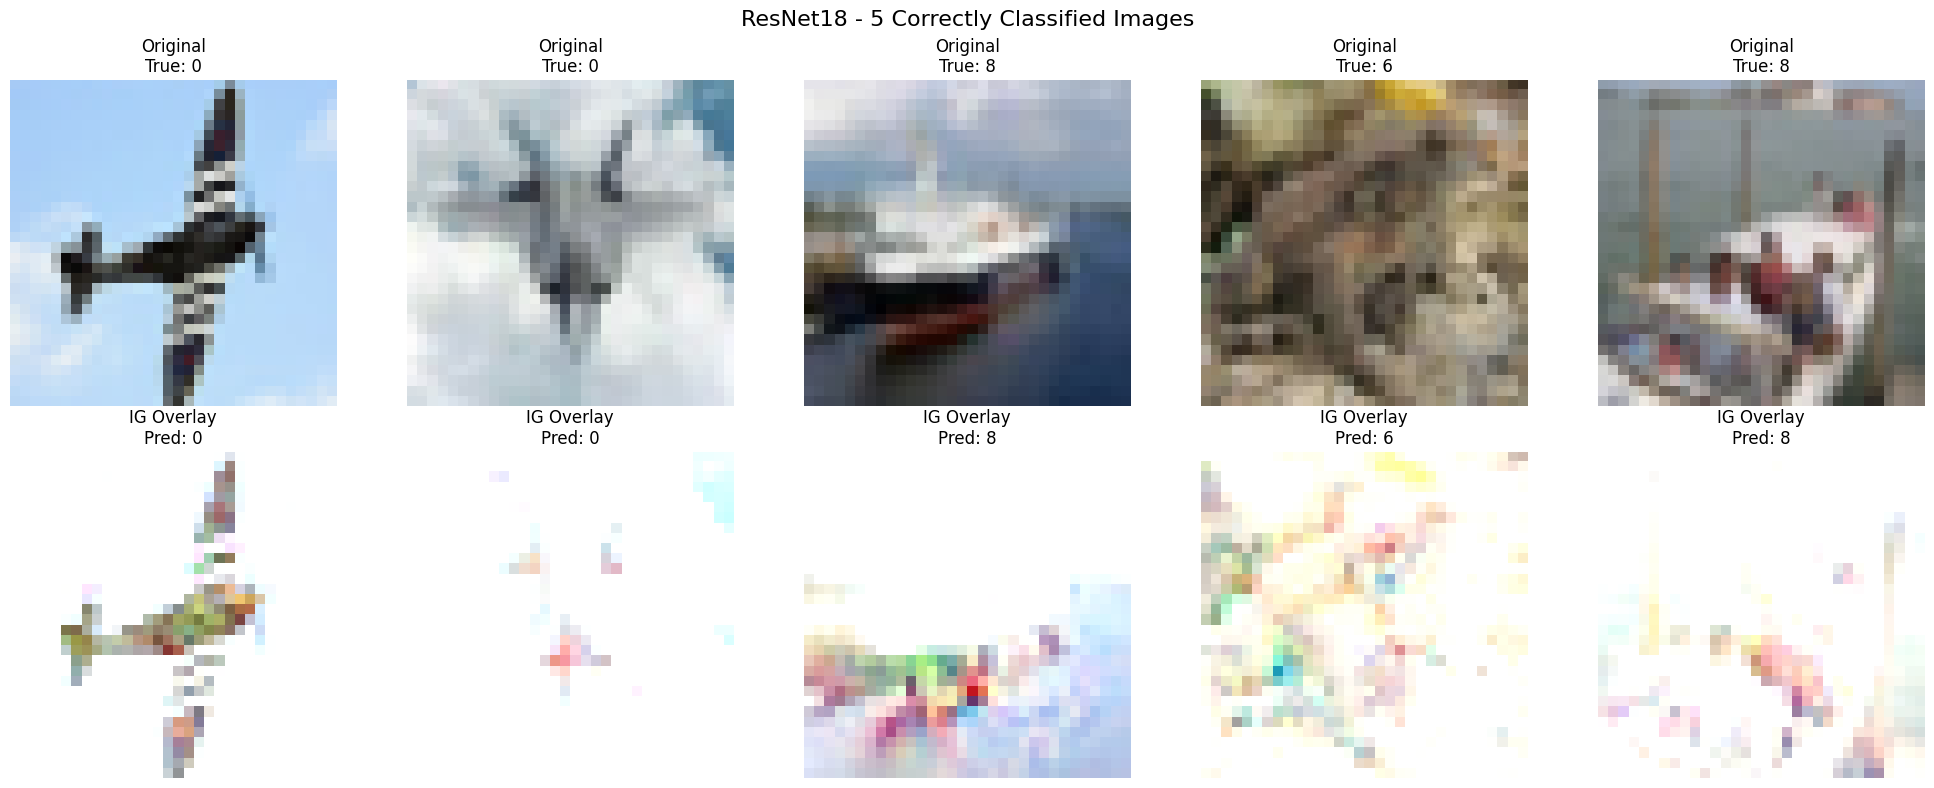

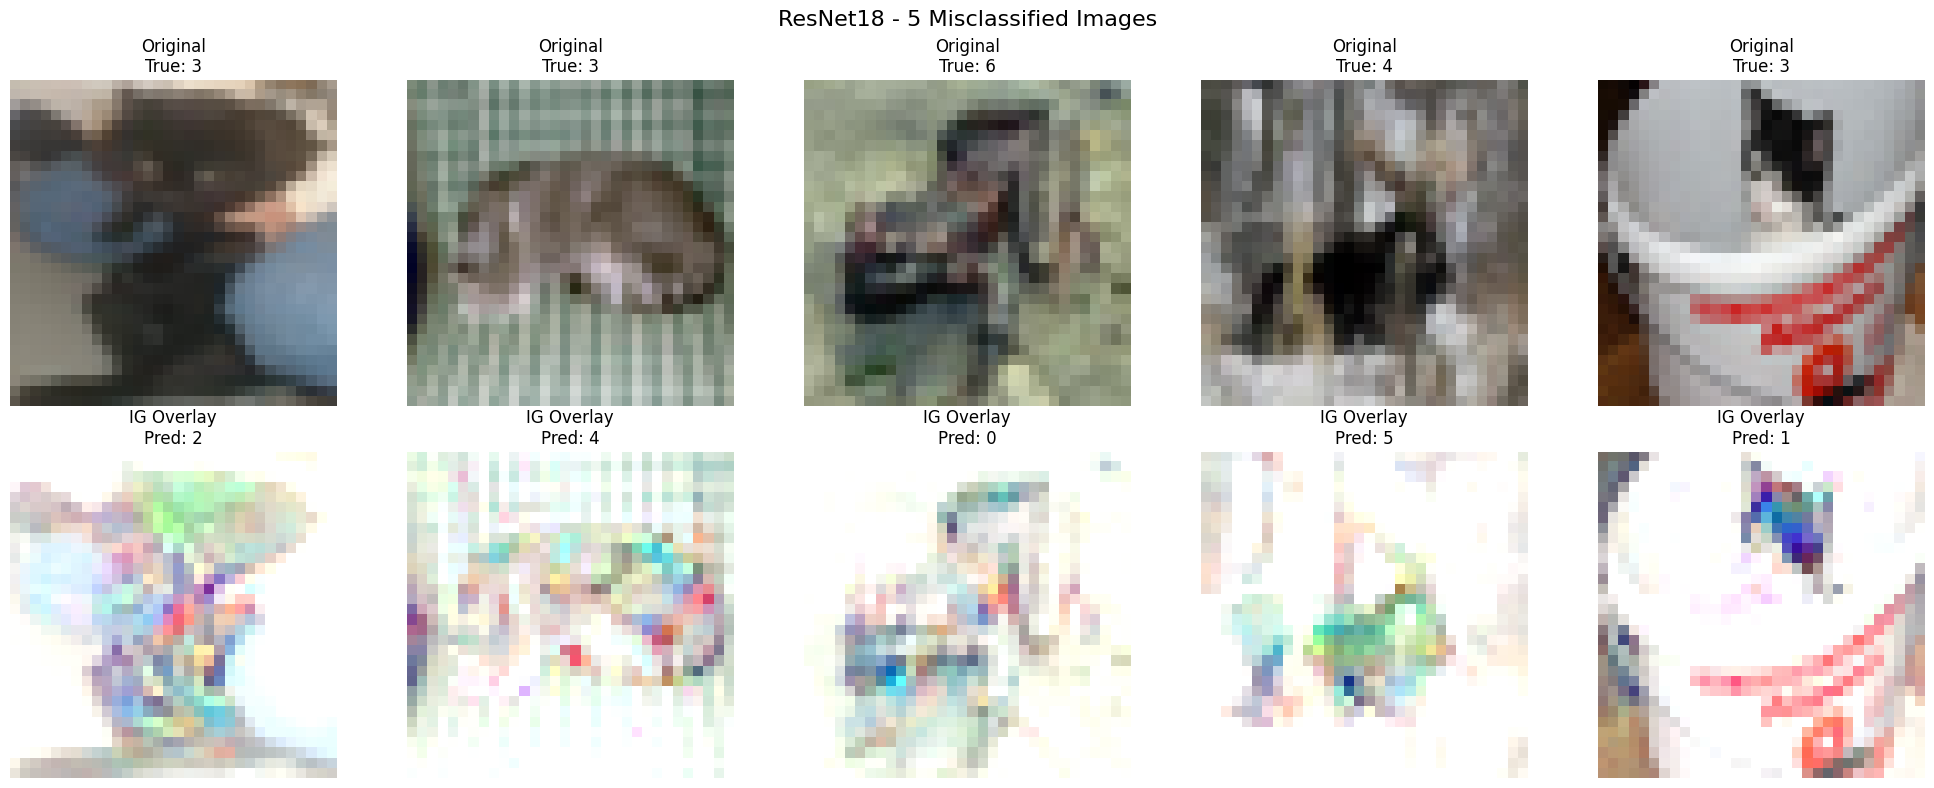


Integrated Gradients visualization for VGG16 ...


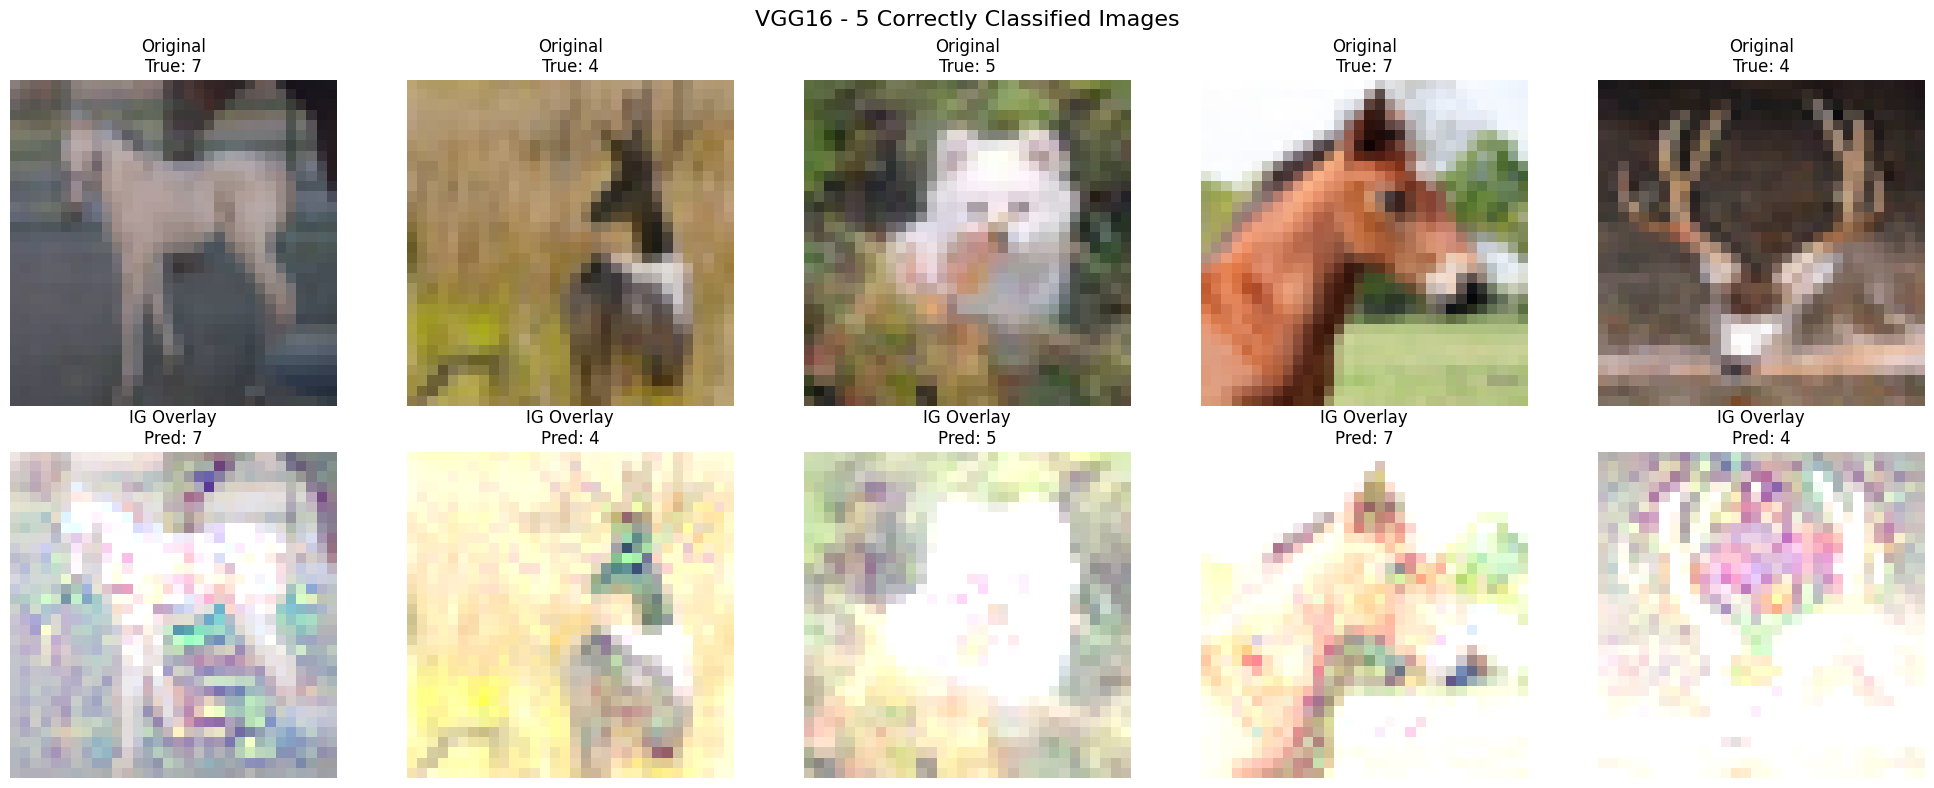

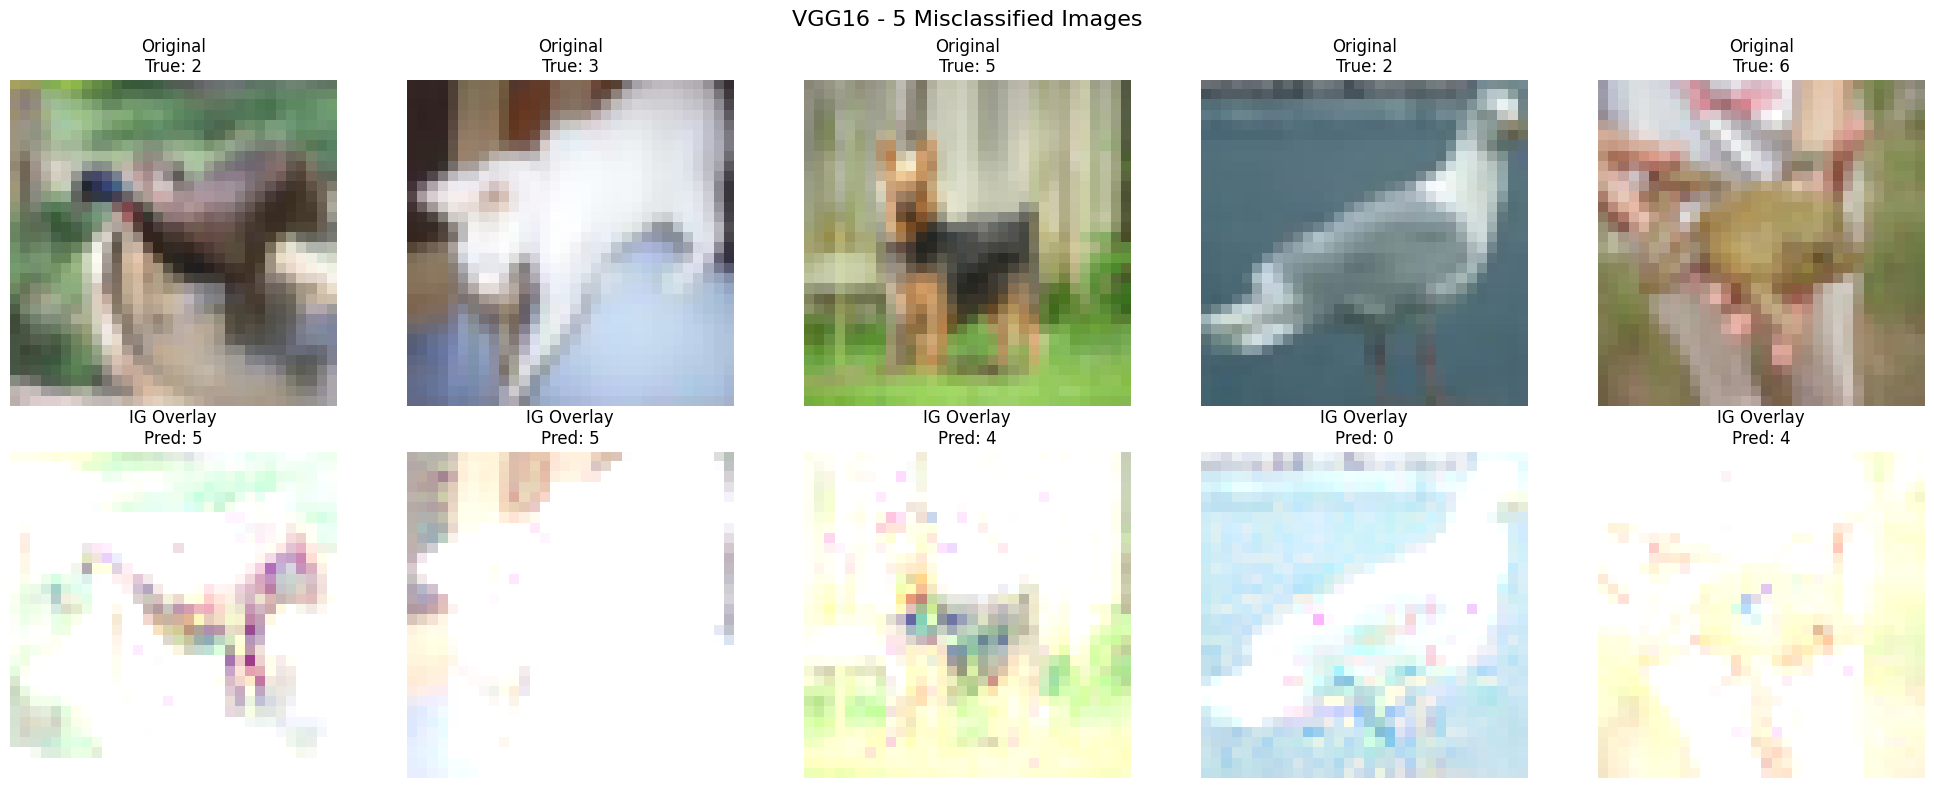

In [37]:
models_dict = {
    'EfficientNet-B0': efficientnet_b0,
    'ResNet18': resnet18,
    'VGG16': vgg16
}

# =======================
# Initialize Integrated Gradients for each model
# =======================
ig_dict = {name: IntegratedGradients(net) for name, net in models_dict.items()}

num_samples = 5  # per category

for model_name, net in models_dict.items():
    print(f"\nIntegrated Gradients visualization for {model_name} ...")
    ig = ig_dict[model_name]
    net.eval()
    
    # Correct / misclassified indices
    correct_indices = [i for i, c in enumerate(all_correct_flags[model_name]) if c]
    misclassified_indices = [i for i, c in enumerate(all_correct_flags[model_name]) if not c]

    def sample_indices(indices):
        return random.sample(indices, min(num_samples, len(indices)))

    def get_ig_image(idx):
        img_np = np.float32(test_images[idx]) / 255.0
        input_tensor = preprocess_image(img_np).requires_grad_(True)
        label = int(test_labels[idx])  # Convert numpy int64 -> Python int
        
        # Compute Integrated Gradients
        attr = ig.attribute(input_tensor, target=label, n_steps=50)
        attr = attr.squeeze().permute(1,2,0).detach().cpu().numpy()  # HWC
        
        # Normalize for visualization
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        
        pred_class = net(input_tensor).argmax(dim=1).item()
        return img_np, attr, pred_class

    def plot_images(indices, title_prefix):
        plt.figure(figsize=(20,8))
        for i, idx in enumerate(indices):
            orig, attr_map, pred = get_ig_image(idx)
            
            # Original image
            plt.subplot(2, num_samples, i+1)
            plt.imshow(orig)
            plt.title(f"Original\nTrue: {test_labels[idx]}")
            plt.axis("off")
            
            # IG overlay
            plt.subplot(2, num_samples, i+1+num_samples)
            overlay = np.clip(orig + attr_map, 0, 1)
            plt.imshow(overlay)
            plt.title(f"IG Overlay\nPred: {pred}")
            plt.axis("off")
        
        plt.suptitle(f"{model_name} - {num_samples} {title_prefix} Images", fontsize=16)
        plt.tight_layout()
        plt.show()

    # Plot correct and misclassified samples
    plot_images(sample_indices(correct_indices), "Correctly Classified")
    plot_images(sample_indices(misclassified_indices), "Misclassified")

Overall i was not able to do properly for Efficient Net part as i dint get the last convolutional layer